In [1]:
from devito import Eq, TimeFunction, sqrt, Function, Operator, Grid, solve
from matplotlib import pyplot as plt
import numpy as np

def Shallow_water_2D(eta0, M0, N0, h0, grid, g, alpha, nt, dx, dy, dt):
    """
    Computes and returns the discharge fluxes M, N and wave height eta from
    the 2D Shallow water equation using the FTCS finite difference method.

    Parameters
    ----------
    eta0 : numpy.ndarray
        The initial wave height field as a 2D array of floats.
    M0 : numpy.ndarray
        The initial discharge flux field in x-direction as a 2D array of floats.
    N0 : numpy.ndarray
        The initial discharge flux field in y-direction as a 2D array of floats.
    h : numpy.ndarray
        Bathymetry model as a 2D array of floats.
    g : float
        gravity acceleration.
    alpha : float
        Manning's roughness coefficient.
    nt : integer
        Number fo timesteps.
    dx : float
        Spatial gridpoint distance in x-direction.
    dy : float
        Spatial gridpoint distance in y-direction.
    dt : float
        Time step.
    """

    eta   = TimeFunction(name='eta', grid=grid, space_order=2)
    M     = TimeFunction(name='M', grid=grid, space_order=2)
    N     = TimeFunction(name='N', grid=grid, space_order=2)
    h     = Function(name='h', grid=grid)
    D     = Function(name='D', grid=grid)

    eta.data[0] = eta0.copy()
    M.data[0]   = M0.copy()
    N.data[0]   = N0.copy()
    D.data[:]   = D0.copy()
    h.data[:]   = h0.copy()

    frictionTerm = g * alpha**2 * sqrt(M**2 + N**2 ) / D**(7./3.)

    pde_eta = Eq(eta.dt + M.dxc + N.dyc)
    pde_M   = Eq(M.dt + (M**2/D).dxc + (M*N/D).dyc + g*D*eta.forward.dxc + frictionTerm*M)
    pde_N   = Eq(N.dt + (M*N/D).dxc + (N**2/D).dyc + g*D*eta.forward.dyc + frictionTerm*N)

    # Defining boundary conditions
    x, y = grid.dimensions
    t = grid.stepping_dim
    bc_left   = Eq(eta[t+1, 0, y], eta[t+1, 1, y])
    bc_right  = Eq(eta[t+1, nx-1, y], eta[t+1, nx-2, y])
    bc_top    = Eq(eta[t+1, x, 0], eta[t+1, x, 1])
    bc_bottom = Eq(eta[t+1, x, ny-1], eta[t+1, x, ny-2])

    stencil_eta = solve(pde_eta, eta.forward)
    stencil_M   = solve(pde_M, M.forward)
    stencil_N   = solve(pde_N, N.forward)

    update_eta  = Eq(eta.forward, stencil_eta, subdomain=grid.interior)
    update_M    = Eq(M.forward, stencil_M, subdomain=grid.interior)
    update_N    = Eq(N.forward, stencil_N, subdomain=grid.interior)
    eq_D        = Eq(D, eta.forward + h)

    optime = Operator([update_eta, bc_left, bc_right, bc_top, bc_bottom,
                       update_M, update_N, eq_D])

    optime(time=nt, dt=dt)
    return eta, M, N

## Example I: Tsunami in an ocean with constant depth

After writing the `Shallow_water_2D` code and all the required functions attached to it, we can define and run our first 2D Tsunami modelling run.

Let's assume that the ocean model is $ L_x = 100\; m$ in x-direction and $L_y = 100\; m$ in y-direction. The model is discretized with $nx=401$ gridpoints in x-direction and $ny=401$ gridpoints in y-direction, respectively.

In this first modelling run, we assume a constant bathymetry $h=50\;m$. The initial wave height field $\eta_0$ is defined as a Gaussian at the center of the model, with a half-width of 10 m and an amplitude of 0.5 m. Regarding the initial discharge fluxes, we assume that 

\begin{equation}
\begin{split}
M_0(x,y) &= 100 \eta_0(x,y)\\
N_0(x,y) &= 0\\
\end{split}\notag
\end{equation}

Furthermore, Dirichlet boundary conditions for the discharge fluxes $M,\;N$ are assumed at all boundaries: 

\begin{equation}
\begin{split}
M(0,y) &= M(L_x,y) = M(x,0) = M(x,L_y) = 0\\  
N(0,y) &= N(L_x,y) = N(x,0) = N(x,L_y) = 0\\  
\end{split} \notag
\end{equation}

For the wave height field $\eta$, it is essential that Neumann boundary conditions are set at all boundaries:

\begin{equation}
\begin{split}
&\frac{\partial \eta}{\partial x}(0,y) = 0\\
&\frac{\partial \eta}{\partial x}(L_x,y) = 0\\
&\frac{\partial \eta}{\partial y}(x,0) = 0\\
&\frac{\partial \eta}{\partial y}(x,L_y) = 0\\
\end{split}\notag
\end{equation}

in order to avoid the occurence of high frequency artifacts, when waves are interacting with the boundaries. Notice, that the assumed boundary conditions lead to significant boundary reflections which might be not realistic for a given problem. However, to keep the problem simple, we will not try to mitigate the boundary reflections. 

In [2]:
Lx    = 100.0   # width of the mantle in the x direction []
Ly    = 100.0   # thickness of the mantle in the y direction []
nx    = 401     # number of points in the x direction
ny    = 401     # number of points in the y direction
dx    = Lx / (nx - 1)  # grid spacing in the x direction []
dy    = Ly / (ny - 1)  # grid spacing in the y direction []
g     = 9.81  # gravity acceleration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition
# Maximum wave propagation time [s]
Tmax  = 1.
dt    = 1/4500.
nt    = (int)(Tmax/dt)
print(dt, nt)

x = np.linspace(0.0, Lx, num=nx)
y = np.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = np.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h0 = 50. * np.ones_like(X)

# Define initial eta Gaussian distribution [m]
eta0 = 0.5 * np.exp(-((X-50)**2/10)-((Y-50)**2/10))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + 50.

grid  = Grid(shape=(ny, nx), extent=(Ly, Lx))

0.00022222222222222223 4500


Allocating memory for eta(2, 405, 405)
Allocating memory for M(2, 405, 405)
Allocating memory for N(2, 405, 405)
Allocating memory for D(403, 403)
Allocating memory for h(403, 403)
Operator `Kernel` generated in 1.17 s
  * lowering.Clusters: 0.66 s (56.7 %)
     * specializing.Clusters: 0.55 s (47.3 %)
        * factorize: 0.36 s (31.0 %)
  * lowering.IET: 0.27 s (23.2 %)
Flops reduction after symbolic optimization: [112 --> 75]
Operator `Kernel` fetched `/run/user/1001/devito-jitcache-uid1001/ab6ad50fffe8ed6008e4de7bd97b70a6fa707a7a.c` in 0.10 s from jit-cache
Operator `Kernel` ran in 39.57 s
Global performance: [OI=0.01, 1.36 GFlops/s, 0.02 GPts/s]
Local performance:
  * section0<4501,399,399> ran in 5.82 s [OI=0.82, 1.61 GFlops/s, 0.13 GPts/s]
  * section2<<4501,401>,<4501,399,399>,<4501,401,401>> ran in 33.75 s [OI=0.01, 1.32 GFlops/s, 0.03 GPts/s]
Performance[mode=advanced] arguments: {}


<function matplotlib.pyplot.show(close=None, block=None)>

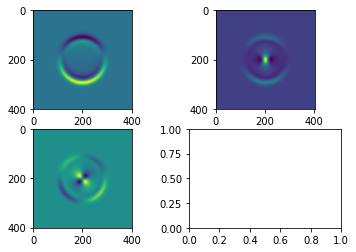

In [5]:
eta, M, N = Shallow_water_2D(eta0, M0, N0, h0, grid, g, alpha, nt, dx, dy, dt)

fig, ax = plt.subplots(2,2)
ax[0,0].imshow(eta.data[1])
ax[0,1].imshow(M.data[1])
ax[1,0].imshow(N.data[1])
plt.show